In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 125

/Users/agnikumar/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


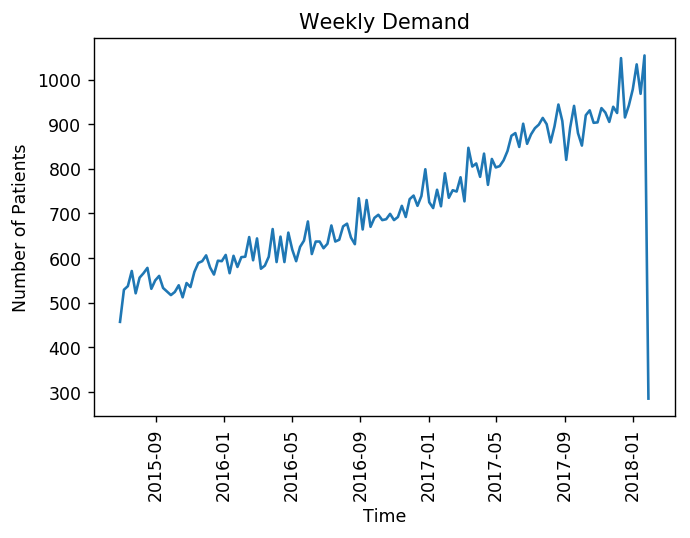

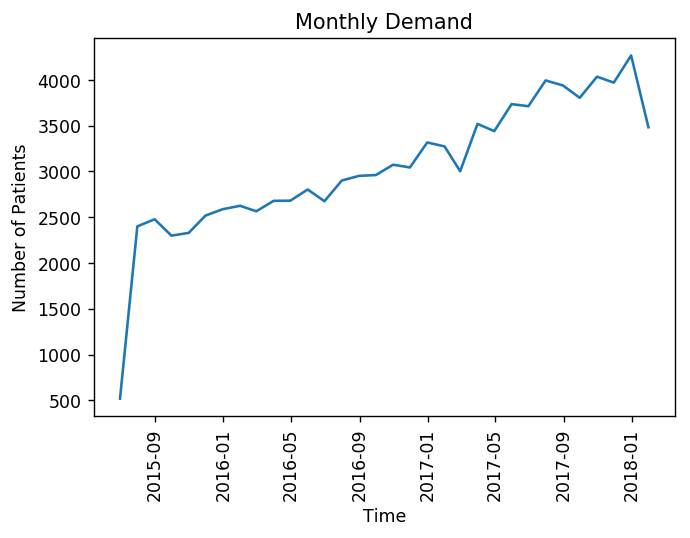

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     499.6
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           4.81e-47
Time:                        22:29:37   Log-Likelihood:                -765.16
No. Observations:                 136   AIC:                             1534.
Df Residuals:                     134   BIC:                             1540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    494.5858     11.542     42.852      0.0

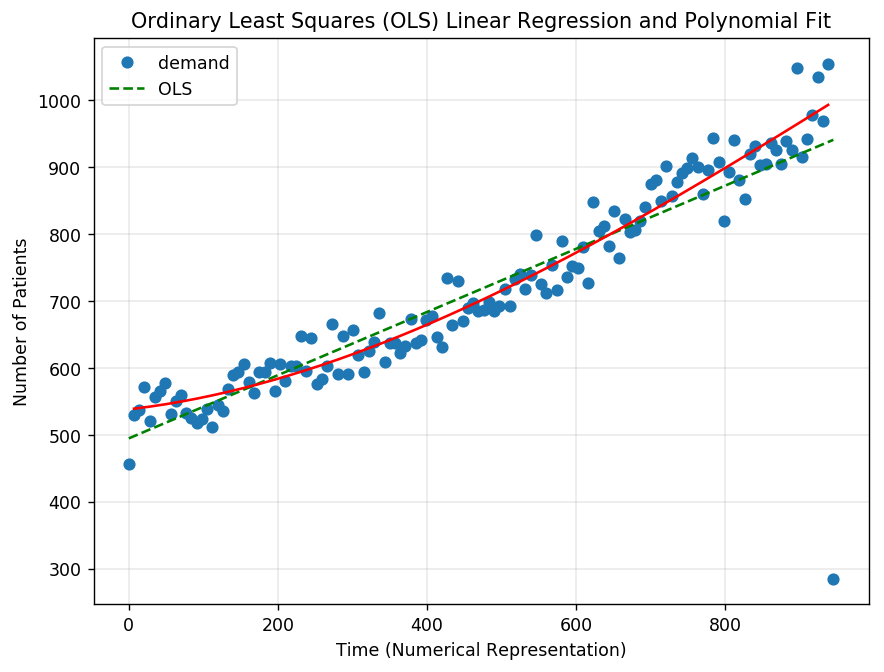

In [3]:
"""
@author: Agni
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from pandas import DataFrame, Series
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# CLEANING DATA
filepath = r'/Users/agnikumar/Documents/MIT 2019-20/neuro-soc/Data/neuro_dataset.xlsx'

df_original = pd.read_excel(filepath, sheetname=0)

df = df_original.copy() # for weekly examination
df_month = df_original.copy() # for monthly examination
#print(df.shape)

df['Name'] = 'Patient'
df['Quantity'] = 1
df['Visit Initiated'] = pd.to_datetime(df['Visit Initiated']) - pd.to_timedelta(7, unit='d')
df = df.groupby(['Name', pd.Grouper(key='Visit Initiated', freq='W-MON')])['Quantity'].sum().reset_index().sort_values('Visit Initiated')

#print(df)
#print(df['Quantity'].sum())

# PLOTTING (Weekly Demand)
plt.title('Weekly Demand')
plt.plot(df['Visit Initiated'], df['Quantity'])
plt.xticks(rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Number of Patients')
plt.show()

# PLOTTING (Monthly Demand)
df_month['Name'] = "Patient"
df_month['Quantity'] = 1
df_month['Visit Initiated'] = pd.to_datetime(df_month['Visit Initiated']) - pd.to_timedelta(7, unit='d')
df_month = df_month.groupby(['Name', pd.Grouper(key='Visit Initiated', freq='M')])['Quantity'].sum().reset_index().sort_values('Visit Initiated')

#print(df_month['Quantity'].sum()) #51394

plt.title('Monthly Demand')
plt.plot(df_month['Visit Initiated'], df_month['Quantity'])
plt.xticks(rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Number of Patients')
plt.show()

# REGRESSION (OLS Linear Regression) on weekly data
df['Visit Initiated'] = pd.to_datetime(df['Visit Initiated'])    
df['date_delta'] = (df['Visit Initiated'] - df['Visit Initiated'].min())  / np.timedelta64(1,'D')
patient_data = df[df['Name'] == 'Patient']
results = sm.ols(formula = 'Quantity ~ date_delta', data = patient_data).fit()

print(results.summary())
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

# OLS non-linear curve but linear in parameters, with confidence intervals (still linear)
x = df['date_delta']
y = df['Quantity']
prstd, iv_l, iv_u = wls_prediction_std(results)

x_without_outliers = x.tolist()[1:-1]
y_without_outliers = y.tolist()[1:-1]

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x, y, 'o', label="demand")
#ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, results.fittedvalues, 'g--', label="OLS")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.xlabel('Time (Numerical Representation)')
plt.ylabel('Number of Patients')
plt.grid(linestyle='-', linewidth=0.25)
plt.title('Ordinary Least Squares (OLS) Linear Regression and Polynomial Fit')
#plt.show()

#print(results.summary())


# REGRESSION (Polynomial Fitting, non-linear) on weekly data

#x = list(df['Visit Initiated'])
#y = list(df['Quantity'])

#x_new = np.linspace(x[0], x[-1], num=len(x)*10)

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]
#y_without_outliers = reject_outliers(y)

#print(type(x))
#print(len(x))
#print(len(y_without_outliers))

coefs = poly.polyfit(x_without_outliers, y_without_outliers, 3)
ffit = poly.polyval(x_without_outliers, coefs)

#plt.title('Polynomial Fitting')
ax.plot(x_without_outliers, ffit, 'r-', label="polyfit")
#plt.show()

print(coefs)